In [16]:
import sys
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parents[1] 
sys.path.append(str(ROOT / "src"))

df = pd.read_csv("../../data/wineQT.csv")

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from gdLinear import GDLinearReg

X = df.drop(columns=["quality", "Id"]).values
y = df["quality"].values

# make polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Cross-validation
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

results_poly = []
for fold, (train_idx, test_idx) in enumerate(cv.split(X_poly)):
    X_train, X_test = X_poly[train_idx], X_poly[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # standardise
    X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
    X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)

    # train model
    model = GDLinearReg(lr=0.01, n_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results_poly.append({"fold": fold+1, "MSE": mse, "RMSE": rmse, "R2": r2})

results_poly_df = pd.DataFrame(results_poly)
print(results_poly_df)
print("Mean:\n", results_poly_df.mean(numeric_only=True))


   fold       MSE      RMSE        R2
0     1  0.385576  0.620947  0.307108
1     2  0.435520  0.659939  0.339147
2     3  0.515090  0.717698  0.269398
3     4  0.444731  0.666882  0.247818
4     5  0.436897  0.660982  0.466012
Mean:
 fold    3.000000
MSE     0.443563
RMSE    0.665289
R2      0.325897
dtype: float64


Polynomial regression with quadratic and interaction terms does not significantly improve performance compared to multiple linear regression.
The R^2 is slightly lower (0.326 vs 0.332), meaning polynomial regression explains slightly less variance in wine quality.
The errors (MSE/RMSE) are marginally higher, showing no real gain in predictive accuracy.
Training time was also longer (polynomials add more features), so the cost/benefit is not favorable here.

                 R2_mean    R2_std  MSE_mean   MSE_std  RMSE_mean
Linear          0.332140  0.065197  0.440494  0.043488   0.663697
Ridge (α=20)    0.334137  0.063283  0.439383  0.044052   0.662859
Lasso (α=0.01)  0.335475  0.062853  0.438883  0.047070   0.662482


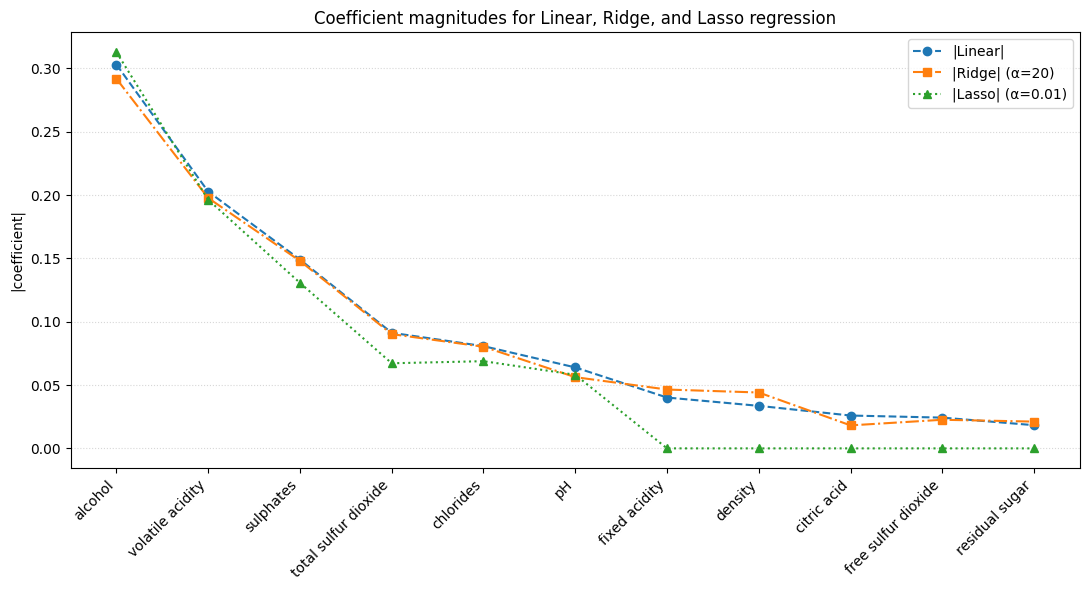

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso


X = df.drop(columns=["quality", "Id"], errors="ignore")
y = df["quality"].values
feature_names = X.columns

# ---- Pipelines (with standardization) ----
pipe_lin   = make_pipeline(StandardScaler(), LinearRegression())
pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=20.0, random_state=42))   
pipe_lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.01, random_state=42, max_iter=10000))

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

def cv_metrics(pipe, X, y):
    r2  = cross_val_score(pipe, X, y, cv=cv, scoring="r2")
    mse = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")
    return {"R2_mean": r2.mean(), "R2_std": r2.std(),
            "MSE_mean": mse.mean(), "MSE_std": mse.std(),
            "RMSE_mean": np.sqrt(mse.mean())}

# ---- CV-results (generalization) ----
results = {
    "Linear": cv_metrics(pipe_lin, X, y),
    "Ridge (α=20)":  cv_metrics(pipe_ridge, X, y),
    "Lasso (α=0.01)":  cv_metrics(pipe_lasso, X, y),
}
print(pd.DataFrame(results).T)

# ---- Fit on the entire dataset to inspect coefficients ----
pipe_lin.fit(X, y)
pipe_ridge.fit(X, y)
pipe_lasso.fit(X, y)

lin_coef   = pipe_lin.named_steps["linearregression"].coef_
ridge_coef = pipe_ridge.named_steps["ridge"].coef_
lasso_coef = pipe_lasso.named_steps["lasso"].coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "Linear":  lin_coef,
    "Ridge":   ridge_coef,
    "Lasso":   lasso_coef,
})
coef_df["|Linear|"] = coef_df["Linear"].abs()
coef_df["|Ridge|"]  = coef_df["Ridge"].abs()
coef_df["|Lasso|"]  = coef_df["Lasso"].abs()

# Sort by max coefficient magnitude across models
top_features = (coef_df
                .assign(max_abs=lambda d: d[["|Linear|","|Ridge|","|Lasso|"]].max(axis=1))
                .sort_values("max_abs", ascending=False)
                .set_index("feature"))

fig, ax = plt.subplots(figsize=(11,6))
ax.plot(top_features.index, top_features["|Linear|"], marker="o", linestyle="--", label="|Linear|")
ax.plot(top_features.index, top_features["|Ridge|"],  marker="s", linestyle="-.", label="|Ridge| (α=20)")
ax.plot(top_features.index, top_features["|Lasso|"],  marker="^", linestyle=":",  label="|Lasso| (α=0.01)")
ax.set_title("Coefficient magnitudes for Linear, Ridge, and Lasso regression")
ax.set_ylabel("|coefficient|")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(True, axis="y", linestyle=":", alpha=0.5)
ax.legend()
plt.tight_layout()
plt.savefig("../figures/ridgeLassoCoeffs.png", bbox_inches="tight")
plt.show()


Ridge shrinks coefficients uniformly and handles correlated predictors better than Linear Regression, which is why it preserves and even emphasizes variables like fixed acidity and density rather than letting them be drowned out by dominant features. Lasso goes further by pruning weaker features completely, leaving only the strongest signals. Overall, Ridge provides more stable coefficients and better generalization when many features contribute, while Lasso improves interpretability by selecting only the most influential predictors.

In [19]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

X = df.drop(columns=["quality", "Id"], errors="ignore")
y = df["quality"].values

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Linear regression
pipe_lin = make_pipeline(StandardScaler(), LinearRegression())
lin_r2  = cross_val_score(pipe_lin, X, y, cv=cv, scoring="r2")
lin_rmse = np.sqrt(-cross_val_score(pipe_lin, X, y, cv=cv, scoring="neg_mean_squared_error"))

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf_r2  = cross_val_score(rf, X, y, cv=cv, scoring="r2")
rf_rmse = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring="neg_mean_squared_error"))

results = pd.DataFrame({
    "Linear R2": [lin_r2.mean()],
    "Linear RMSE": [lin_rmse.mean()],
    "RF R2": [rf_r2.mean()],
    "RF RMSE": [rf_rmse.mean()]
})
print(results)


   Linear R2  Linear RMSE     RF R2   RF RMSE
0    0.33214     0.662892  0.426732  0.614605


Random Forest R² = 0.427 vs Linear R² = 0.332 → RF explains more of the variance in wine quality.
Random Forest RMSE = 0.615 vs Linear RMSE = 0.663 → RF achieves lower prediction error.
Therefore Random Forest performs better.